In [1]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, BinaryCrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

n, s = Ty('n'), Ty('s')
# nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("ja_ginza")

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
# データセット読み込み
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            # labels.append([[0, t],[0, 1-t]]) # 2×2行列の形で格納するならこっち
            labels.append([1-t, t]) # 1×2行列の形
            sentences.append(line[1:].strip())
            
    return np.array(labels), sentences

train_labels, train_sentences = read_data('C:/Users/neoia/wiki_traindata.txt')
dev_labels, dev_sentences = read_data('C:/Users/neoia/wiki_devdata.txt')
test_labels, test_sentences = read_data('C:/Users/neoia/wiki_testdata.txt')


In [4]:
train_sentences

['これらのプロセスはプログラミングのプロセスの一部と考えられるが、広義のプロセスはよく「ソフトウェア開発」と呼ばれ、実際にコードを書く行為に対しては、「プログラミング」、「実装」、「コーディング」という名前が使われることが多い。',
 'プログラムはカムにあり、それによって小さなてこを押して、打楽器を演奏する。',
 'カムは実際には円筒にペグが突き刺された形であり、このペグの配置でプログラミングし、演奏パターンを変更した。',
 'この機械は、穴を開けた一連の厚紙（パンチカードの原型）を使った。',
 '食材についている土やほこりなどの汚れを洗浄する。',
 '最古のプログラマブルな機械（プログラムによって動作の変化を制御できる機械）としては、1206年にアル＝ジャザリが作った二足歩行ロボットがあると言われている。',
 '料理は、民族、地域、時代などにより、使用する食材や道具などが大きく異なり、調理の仕方にも差がある。',
 '一方で、遺跡である貝塚が全世界に分布することから推測されるように、牡蠣の殻を取り除き柑橘類を合わせた酢牡蠣のような料理が地域や時代において幅広く存在することもある。',
 '切る以外に「おろす」（すりおろす）、叩くなどの方法もある。',
 '例えば、クリ属は自然に分布していて秋の季語でもあり、旬の栗拾いや栗名月をへて備蓄し、この栗の実の皮をむき煮た栗金団という食品は、正月に用いれば御節料理となるし、菓子となることもある。',
 '穴の配列が布を織る際のパターンに対応している。',
 'これがプログラミングへの第一歩である。',
 '骨・内臓などを取り除き、身（肉）の部分を切り分ける。',
 '1830年ごろには、チャールズ・バベッジがパンチカードを使った解析機関を考案した。',
 '「ハッカー」とは、技術的な知識を使って問題を解決する技術のあるすべてのコンピュータの専門家を表す言葉であるが、一般的な用語では「セキュリティハッカー（英語版）」と同じ意味でも使われている。',
 'この加工の過程は「調理」というが、区別されず「料理する」と呼ばれることもある。',
 '料理の定義は曖昧であり、「加熱処理(焼く、炒める、揚げる、茹でる、煮る、蒸す、炊くなど)の施されている食品」のみを「料理」と呼ぶ場合や、前述の調理法を使う物に加え「生ではあるが

In [5]:
# 型の割り当て
def assign_types(doc):
    pregroup_types = {}
    doc = nlp(sentence)
    # トークン化
    tokens = [token.text for token in doc]
    # 依存関係をまとめる
    # dependencies = [(token.text, token.head.text) for token in doc if token.text != "."]
    dependencies = []
    
    for token in doc:
        if token.dep_ == 'ROOT':
            pregroup_types[token.text] = s
            dependencies.append((token.text, token.head.text))
        elif token.pos_ == 'NOUN':
            pregroup_types[token.text] = n
            if token.head.dep_ == 'ROOT':
                dependencies.append((token.text, token.head.text))

    # 依存関係による型の割り当て（ペアと語順）
    for token in doc:
        for dep in dependencies:
            if token.text == dep[1]:
                idx1 = tokens.index(dep[0])
                idx2 = tokens.index(dep[1])
                if pregroup_types[dep[0]] == n:
                    if idx1 < idx2:
                        pregroup_types[token.text] = n.r @ pregroup_types[token.text]
                    else:
                        pregroup_types[token.text] = pregroup_types[token.text] @ n.l
                # elif pregroup_types[dep[0]] == s:
                    # if idx1 < idx2:
                        # pregroup_types[token.text] = s.r @ pregroup_types[token.text]
                    # else:
                        # pregroup_types[token.text] = pregroup_types[token.text] @ s.l
    
    return pregroup_types

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 日本語フォントを設定
font_path = "C:\\Windows\\Fonts\\meiryo.ttc" 
jp_font = fm.FontProperties(fname=font_path) 
# matplotlibにフォントを設定
rcParams['font.family'] = jp_font.get_name()

# creating diagram
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # making cups
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

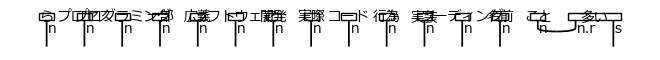

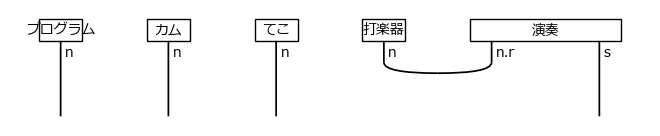

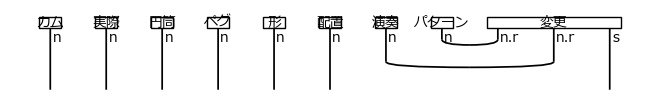

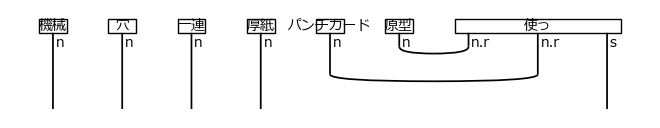

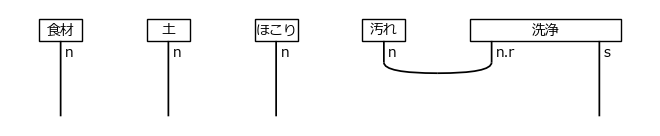

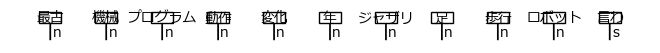

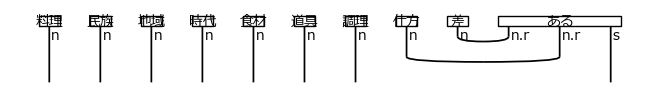

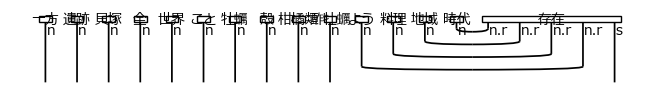

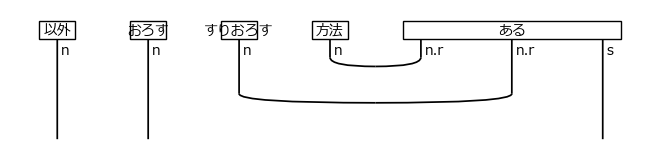

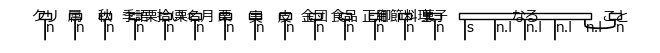

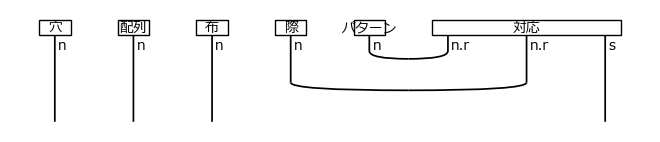

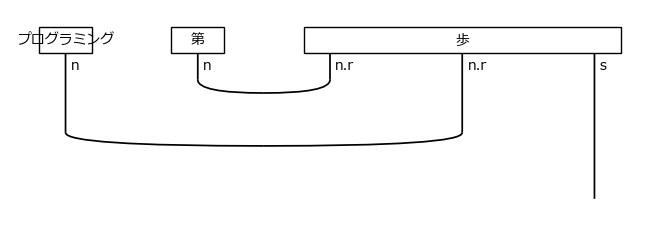

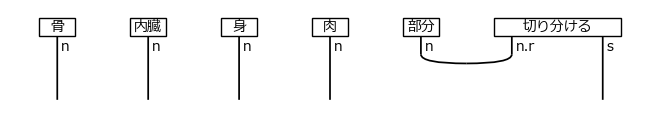

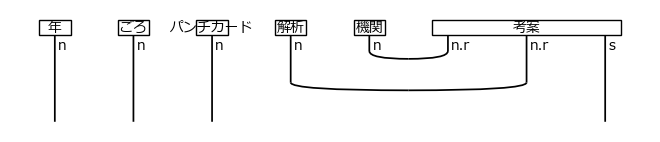

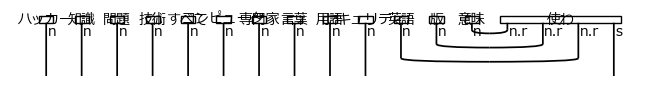

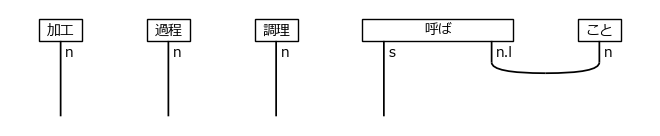

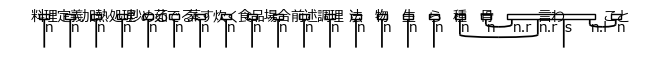

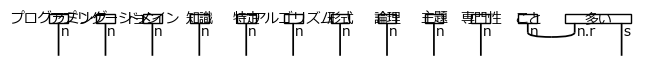

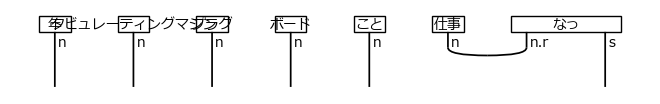

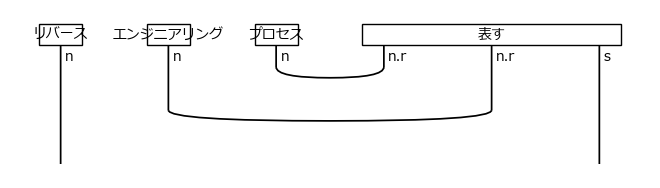

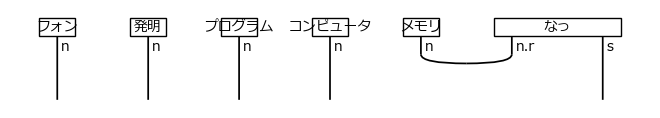

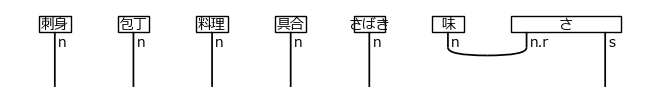

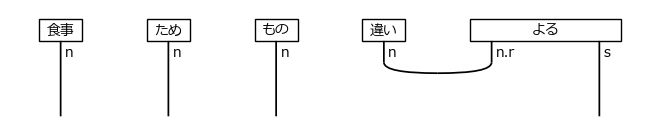

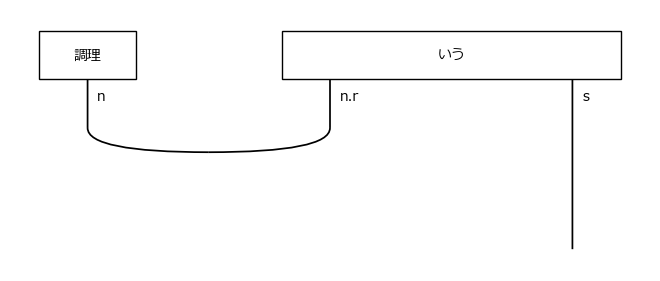

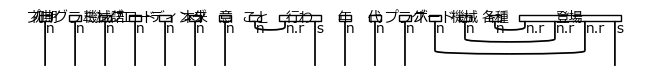

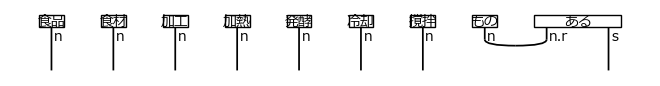

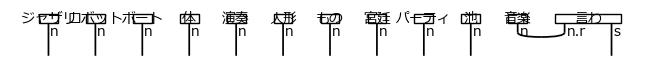

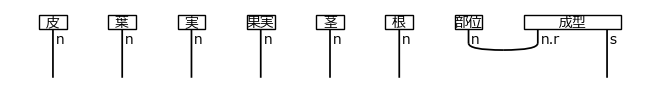

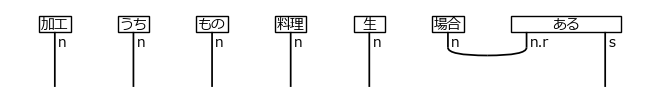

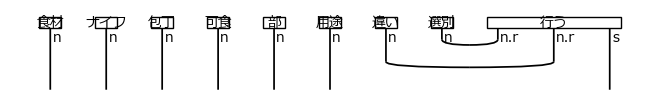

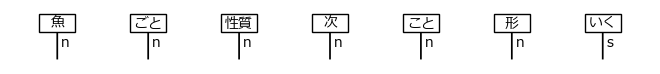

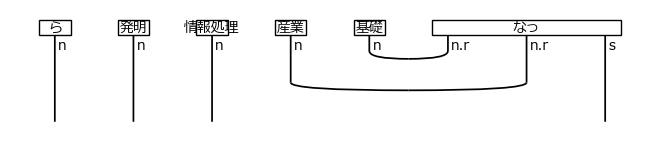

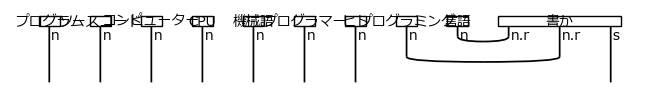

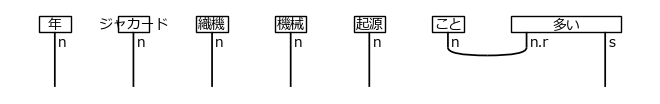

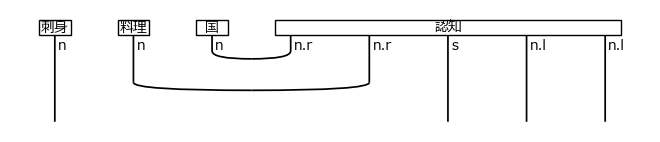

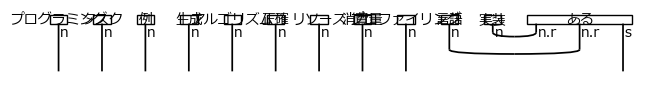

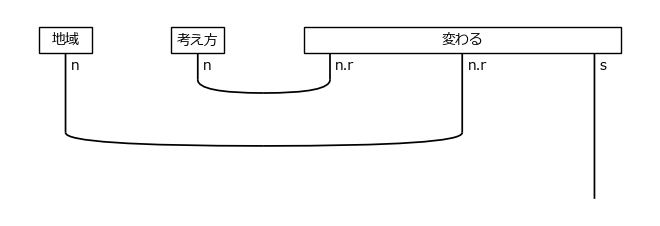

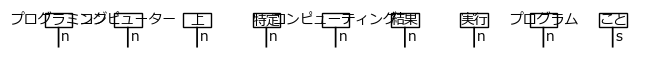

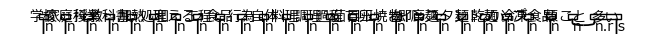

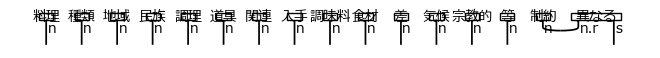

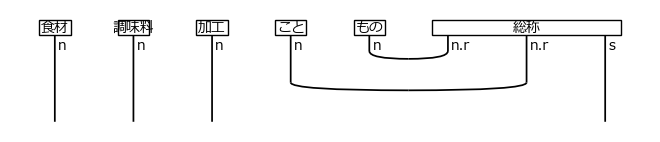

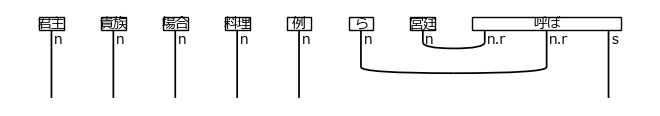

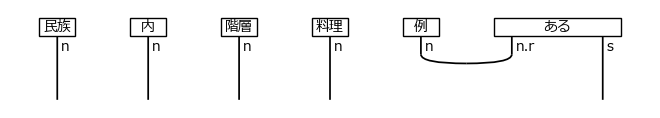

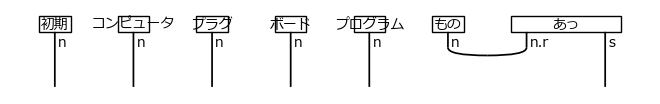

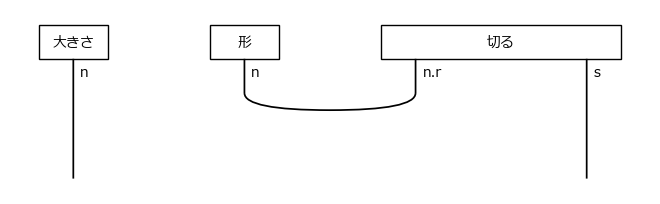

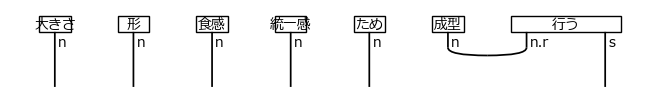

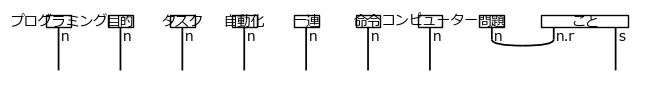

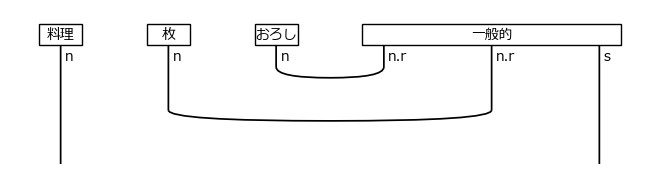

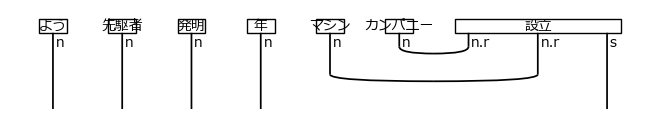

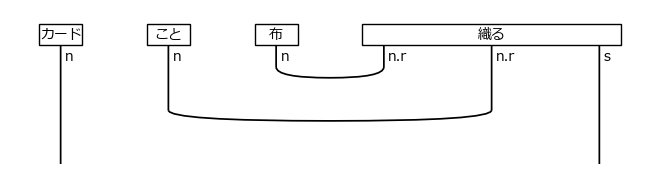

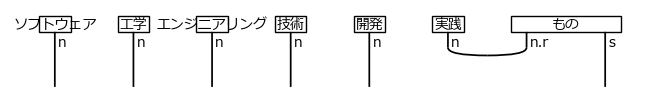

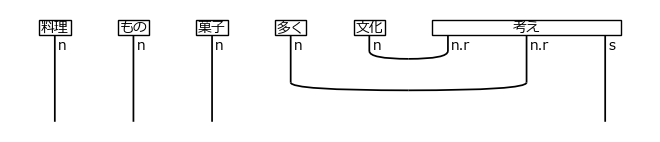

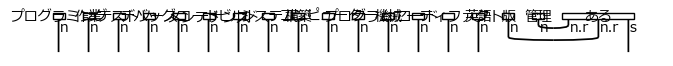

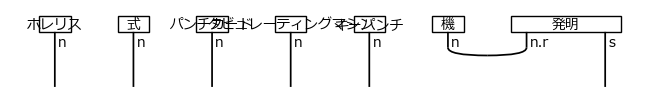

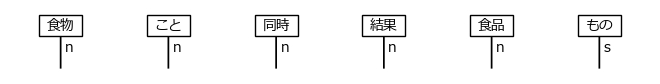

In [7]:
train_diagrams = []
dev_diagrams = []
test_diagrams = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    train_diagrams.append(create_diagram(sentence))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    dev_diagrams.append(create_diagram(sentence))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    test_diagrams.append(create_diagram(sentence))

# check diagrams
for d in range(len(train_sentences)):
    draw(train_diagrams[d])

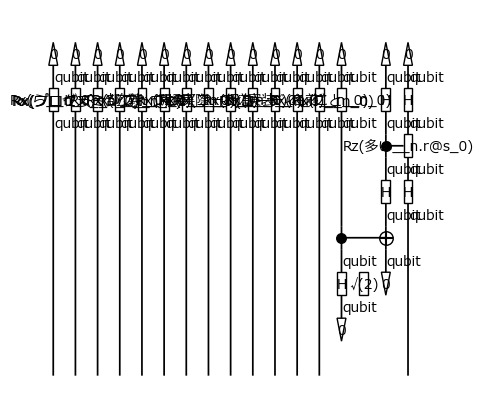

In [8]:
# 量子回路設計（IQPAnsatz）
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=1)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(4, 4))